<a href="https://colab.research.google.com/github/drshahizan/Python_Tutorial/blob/main/big%20data/modin/lab_5_IntelModin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# =============================================================
# Copyright © 2020 Intel Corporation
# 
# SPDX-License-Identifier: MIT
# =============================================================

# Lab 5: Modin for Distributed Pandas

## Importing and Organizing Data

We will be generating a **synthetic dataset** and **demonstrating stock Pandas operations running with Modin**.

Let's start by **importing** all the necessary packages and modules

In [ ]:
!pip install modin[all] 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 970 kB 5.2 MB/s 
     |████████████████████████████████| 12.2 MB 45.5 MB/s 
     |████████████████████████████████| 68 kB 7.5 MB/s 
     |████████████████████████████████| 102 kB 64.2 MB/s 
     |████████████████████████████████| 132 kB 68.4 MB/s 
     |████████████████████████████████| 1.8 MB 70.2 MB/s 
     |████████████████████████████████| 57.4 MB 1.2 MB/s 
     |████████████████████████████████| 117 kB 71.3 MB/s 
     |████████████████████████████████| 439 kB 66.5 MB/s 
     |████████████████████████████████| 1.6 MB 57.9 MB/s 
     |████████████████████████████████| 121 kB 71.1 MB/s 
     |████████████████████████████████| 423 kB 72.1 MB/s 
     |████████████████████████████████| 9.8 MB 74.6 MB/s 
     |████████████████████████████████| 360 kB 78.1 MB/s 
     |████████████████████████████████| 273 kB 80.9 MB/s 
     |███████████████████████████

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [ ]:
# ****** Do not change the code in this cell! It verifies that the notebook is being run correctly! ******

def verify_and_print_times(pandas_time, modin_time):
    if modin_time < pandas_time:
        print(f"Modin was {pandas_time / modin_time:.2f}X faster than stock pandas!")
        return
    print(
        f"Oops, stock pandas appears to be {modin_time / pandas_time:.2f}X faster than Modin in this case. "
        "This is unlikely but could happen sometimes on certain machines/environments/datasets. "
        "One of the most probable reasons is the excessive amount of partitions being assigned to a single worker. "
        "You may visit Modin's optimization guide in order to learn more about such cases and how to fix them: "
        "\nhttps://modin.readthedocs.io/en/latest/usage_guide/optimization_notes/index.html\n\n"
        "But first, verify that you're using the latest Modin version, also, try to use different executions, "
        "for basic usage we recommend non-experimental 'PandasOnRay'.\n"
        "Current configuration is:"
    )
    try:
        from modin.utils import get_current_execution

        execution = get_current_execution()
    except ImportError:
        # for modin version < 0.12.0
        try:
            from modin.utils import get_current_backend

            execution = get_current_backend()
        except ImportError:
            # for modin versions < 0.8.1
            execution = (
                "Can't deduce the current execution, your Modin version is too old!"
            )
    print(f"\tExecution: {execution}")
    try:
        import modin.config as cfg

        print(
            f"\tIs experimental: {cfg.IsExperimental.get()}\n"
            f"\tNumber of CPUs to utilize by Modin (check that Modin uses all CPUs on your machine): {cfg.CpuCount.get()}\n"
            f"\tIs in debug mode (debug mode may perform slower): {cfg.IsDebug.get()}"
        )
    except (ImportError, AttributeError):
        # for modin versions < 0.8.2
        print("\tCan't deduce Modin configuration, your Modin version is too old!")
    import modin

    print(f"\tModin version: {modin.__version__}")

## How to Use Modin

We will also be importing **stock Pandas as pandas** and **Modin as pd to show differentiation**. You can see importing Modin is simple and **does not require any additional steps.**

In [ ]:
import pandas

**Note: Uncomment below cell if you run on Intel oneAPI DevCloud**

In [ ]:
# import ray
# ray.shutdown()
# ray.init(_memory=16000 * 1024 * 1024, object_store_memory=500 * 1024 * 1024,_driver_object_store_memory=500 * 1024 * 1024)

In [ ]:
import modin.pandas as pd

We will now **generate a synthetic dataset** using NumPy to use with Modin and save it to a CSV.

In [ ]:
array=np.random.randint(low=100,high=10000,size=(2**18,2**8))
#array
np.savetxt("foo.csv", array, delimiter=",") #how to generate array

Now we will convert the ndarray into a Pandas dataframe and display the first five rows.
For **stock pandas, the dataframe is being stored as `pandas_df`** and for **Modin, the same dataframe is being stored as `modin_df`**.
Let's try running the following cell with Pandas first.

In [ ]:
%%time
pandas_df = pandas.read_csv("foo.csv", names=["col{}".format(i) for i in range(256)])
pandas_df.head()

CPU times: user 16.5 s, sys: 1.61 s, total: 18.1 s
Wall time: 18.1 s


,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,...,col246,col247,col248,col249,col250,col251,col252,col253,col254,col255
0,3905.0,5729.0,8544.0,342.0,2805.0,2231.0,8700.0,9212.0,6938.0,3664.0,...,8906.0,1586.0,2578.0,420.0,6894.0,7126.0,2321.0,2000.0,5026.0,7089.0
1,6928.0,7636.0,5818.0,9505.0,1441.0,5137.0,3535.0,1908.0,6570.0,2166.0,...,2186.0,4112.0,1035.0,8678.0,9039.0,2437.0,4353.0,123.0,466.0,4311.0
2,1857.0,5619.0,3362.0,8788.0,9332.0,3990.0,3158.0,1338.0,1037.0,1569.0,...,3488.0,7193.0,8961.0,8522.0,1265.0,5017.0,2896.0,4466.0,2499.0,6288.0
3,4963.0,193.0,3808.0,7341.0,653.0,9363.0,5389.0,4831.0,5710.0,6625.0,...,9075.0,188.0,6907.0,7328.0,4915.0,512.0,8747.0,3777.0,492.0,9686.0
4,3404.0,3207.0,6846.0,7135.0,6500.0,1287.0,4279.0,4274.0,8769.0,9360.0,...,7781.0,4338.0,3489.0,8619.0,3065.0,8668.0,329.0,6166.0,2657.0,663.0


Now let's run the same code, but use **Modin instead of stock Pandas.**

**Note the speedup!**

In [ ]:
%%time
modin_df=pd.read_csv("foo.csv", names=["col{}".format(i) for i in range(256)])
modin_df.head()

To remove this warning, run the following python code before doing dataframe operations:

    import ray
    ray.init(runtime_env={'env_vars': {'__MODIN_AUTOIMPORT_PANDAS__': '1'}})

2022-12-21 07:38:35,605	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


CPU times: user 3.57 s, sys: 1.45 s, total: 5.01 s
Wall time: 33.6 s


,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,...,col246,col247,col248,col249,col250,col251,col252,col253,col254,col255
0,3905.0,5729.0,8544.0,342.0,2805.0,2231.0,8700.0,9212.0,6938.0,3664.0,...,8906.0,1586.0,2578.0,420.0,6894.0,7126.0,2321.0,2000.0,5026.0,7089.0
1,6928.0,7636.0,5818.0,9505.0,1441.0,5137.0,3535.0,1908.0,6570.0,2166.0,...,2186.0,4112.0,1035.0,8678.0,9039.0,2437.0,4353.0,123.0,466.0,4311.0
2,1857.0,5619.0,3362.0,8788.0,9332.0,3990.0,3158.0,1338.0,1037.0,1569.0,...,3488.0,7193.0,8961.0,8522.0,1265.0,5017.0,2896.0,4466.0,2499.0,6288.0
3,4963.0,193.0,3808.0,7341.0,653.0,9363.0,5389.0,4831.0,5710.0,6625.0,...,9075.0,188.0,6907.0,7328.0,4915.0,512.0,8747.0,3777.0,492.0,9686.0
4,3404.0,3207.0,6846.0,7135.0,6500.0,1287.0,4279.0,4274.0,8769.0,9360.0,...,7781.0,4338.0,3489.0,8619.0,3065.0,8668.0,329.0,6166.0,2657.0,663.0


Let's now **visualize** this speedup from Modin with a plot!

In [ ]:
def plotter(outputdict):
    fig = plt.figure(figsize = (10, 5)) 
    plt.bar(outputdict.keys(),outputdict.values(),color='blue',width=0.4)
    plt.xlabel("Python Package")
    plt.ylabel("Runtime(seconds)")
    plt.show()

Pandas Time(seconds): 20.273156881332397 
Modin Time(seconds): 18.298872470855713
Modin was 1.11X faster than stock pandas!


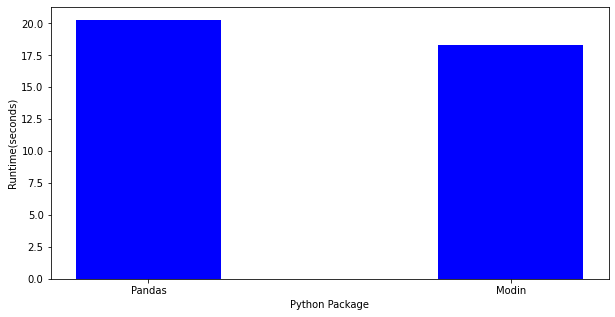

In [ ]:
t0 = time.time()
pandas_df = pandas.read_csv("foo.csv", names=["col{}".format(i) for i in range(256)])
pandas_time = time.time()- t0

t1 = time.time()
modin_df = pd.read_csv("foo.csv", names=["col{}".format(i) for i in range(256)])
modin_time = time.time() - t1

print("Pandas Time(seconds):",pandas_time,"\nModin Time(seconds):",modin_time)
verify_and_print_times(pandas_time, modin_time)
outputDict={"Pandas":pandas_time,"Modin":modin_time}
plotter(outputDict)

## Other DataFrame Function Performance Example
We will now show the speedup in performance from Modin compared to stock Pandas with a few common functions.

Like before, **`pandas_df` is for  stock Pandas**, **`modin_df` is for Modin**.

### `df.mean()`

In [ ]:
# Mean
t2 = time.time()
pandas_df.mean(axis=0)
pandas_time=time.time()- t2
print(" stock Pandas wall time for completion in seconds:",pandas_time)

 stock Pandas wall time for completion in seconds: 0.24925947189331055


In [ ]:
# Mean
t3 = time.time()
modin_df.mean(axis=0)
modin_time=time.time()- t3
print("Modin wall time for completion in seconds:",modin_time)

Modin wall time for completion in seconds: 0.03903508186340332


In [ ]:
verify_and_print_times(pandas_time, modin_time)

Modin was 6.39X faster than stock pandas!


### `df.applymap`

In [ ]:
# Long apply function
t6 = time.time()
print(pandas_df.applymap(lambda x: x + 1))
pandas_time = time.time() - t6
print(" stock Pandas wall time for completion in seconds:",pandas_time)

          col0    col1    col2    col3    col4    col5    col6    col7  \
0       3906.0  5730.0  8545.0   343.0  2806.0  2232.0  8701.0  9213.0   
1       6929.0  7637.0  5819.0  9506.0  1442.0  5138.0  3536.0  1909.0   
2       1858.0  5620.0  3363.0  8789.0  9333.0  3991.0  3159.0  1339.0   
3       4964.0   194.0  3809.0  7342.0   654.0  9364.0  5390.0  4832.0   
4       3405.0  3208.0  6847.0  7136.0  6501.0  1288.0  4280.0  4275.0   
...        ...     ...     ...     ...     ...     ...     ...     ...   
262139  1201.0  6230.0  4138.0  8653.0  2757.0  7207.0  6880.0  4563.0   
262140  6673.0  2380.0   865.0  5868.0  3678.0  6432.0   445.0  1293.0   
262141  6960.0  3208.0  7004.0  7750.0  5902.0  5816.0  3893.0  8888.0   
262142  3595.0  8907.0   768.0  9022.0  6267.0  2640.0  6492.0  2408.0   
262143  3206.0  2930.0  6941.0  3344.0  4907.0  4322.0  9175.0  8634.0   

          col8    col9  ...  col246  col247  col248  col249  col250  col251  \
0       6939.0  3665.0  ...  890

In [ ]:
# Long apply function
t7 = time.time()
print(modin_df.applymap(lambda x: x + 1))
modin_time = time.time() - t7
print("Modin wall time for completion in seconds:",modin_time)

          col0    col1    col2    col3    col4    col5    col6    col7  \
0       3906.0  5730.0  8545.0   343.0  2806.0  2232.0  8701.0  9213.0   
1       6929.0  7637.0  5819.0  9506.0  1442.0  5138.0  3536.0  1909.0   
2       1858.0  5620.0  3363.0  8789.0  9333.0  3991.0  3159.0  1339.0   
3       4964.0   194.0  3809.0  7342.0   654.0  9364.0  5390.0  4832.0   
4       3405.0  3208.0  6847.0  7136.0  6501.0  1288.0  4280.0  4275.0   
...        ...     ...     ...     ...     ...     ...     ...     ...   
262139  1201.0  6230.0  4138.0  8653.0  2757.0  7207.0  6880.0  4563.0   
262140  6673.0  2380.0   865.0  5868.0  3678.0  6432.0   445.0  1293.0   
262141  6960.0  3208.0  7004.0  7750.0  5902.0  5816.0  3893.0  8888.0   
262142  3595.0  8907.0   768.0  9022.0  6267.0  2640.0  6492.0  2408.0   
262143  3206.0  2930.0  6941.0  3344.0  4907.0  4322.0  9175.0  8634.0   

          col8    col9  ...  col246  col247  col248  col249  col250  col251  \
0       6939.0  3665.0  ...  890

In [ ]:
verify_and_print_times(pandas_time, modin_time)

Oops, stock pandas appears to be 1.04X faster than Modin in this case. This is unlikely but could happen sometimes on certain machines/environments/datasets. One of the most probable reasons is the excessive amount of partitions being assigned to a single worker. You may visit Modin's optimization guide in order to learn more about such cases and how to fix them: 
https://modin.readthedocs.io/en/latest/usage_guide/optimization_notes/index.html

But first, verify that you're using the latest Modin version, also, try to use different executions, for basic usage we recommend non-experimental 'PandasOnRay'.
Current configuration is:
	Execution: PandasOnRay
	Is experimental: None
	Number of CPUs to utilize by Modin (check that Modin uses all CPUs on your machine): 2
	Is in debug mode (debug mode may perform slower): None
	Modin version: 0.18.0


### `pd.concat([df, df])`

In [ ]:
# Concat
t8 = time.time()
print(pandas.concat([pandas_df, pandas_df], axis=0))
pandas_time = time.time() - t8
print("stock Pandas wall time for completion in seconds:",pandas_time)

          col0    col1    col2    col3    col4    col5    col6    col7  \
0       3905.0  5729.0  8544.0   342.0  2805.0  2231.0  8700.0  9212.0   
1       6928.0  7636.0  5818.0  9505.0  1441.0  5137.0  3535.0  1908.0   
2       1857.0  5619.0  3362.0  8788.0  9332.0  3990.0  3158.0  1338.0   
3       4963.0   193.0  3808.0  7341.0   653.0  9363.0  5389.0  4831.0   
4       3404.0  3207.0  6846.0  7135.0  6500.0  1287.0  4279.0  4274.0   
...        ...     ...     ...     ...     ...     ...     ...     ...   
262139  1200.0  6229.0  4137.0  8652.0  2756.0  7206.0  6879.0  4562.0   
262140  6672.0  2379.0   864.0  5867.0  3677.0  6431.0   444.0  1292.0   
262141  6959.0  3207.0  7003.0  7749.0  5901.0  5815.0  3892.0  8887.0   
262142  3594.0  8906.0   767.0  9021.0  6266.0  2639.0  6491.0  2407.0   
262143  3205.0  2929.0  6940.0  3343.0  4906.0  4321.0  9174.0  8633.0   

          col8    col9  ...  col246  col247  col248  col249  col250  col251  \
0       6938.0  3664.0  ...  890

In [ ]:
# Concat
t9 = time.time()
print(pd.concat([modin_df, modin_df], axis=0))
modin_time = time.time() - t9
print("Modin wall time for completion in seconds:",modin_time)

          col0    col1    col2    col3    col4    col5    col6    col7  \
0       3905.0  5729.0  8544.0   342.0  2805.0  2231.0  8700.0  9212.0   
1       6928.0  7636.0  5818.0  9505.0  1441.0  5137.0  3535.0  1908.0   
2       1857.0  5619.0  3362.0  8788.0  9332.0  3990.0  3158.0  1338.0   
3       4963.0   193.0  3808.0  7341.0   653.0  9363.0  5389.0  4831.0   
4       3404.0  3207.0  6846.0  7135.0  6500.0  1287.0  4279.0  4274.0   
...        ...     ...     ...     ...     ...     ...     ...     ...   
262139  1200.0  6229.0  4137.0  8652.0  2756.0  7206.0  6879.0  4562.0   
262140  6672.0  2379.0   864.0  5867.0  3677.0  6431.0   444.0  1292.0   
262141  6959.0  3207.0  7003.0  7749.0  5901.0  5815.0  3892.0  8887.0   
262142  3594.0  8906.0   767.0  9021.0  6266.0  2639.0  6491.0  2407.0   
262143  3205.0  2929.0  6940.0  3343.0  4906.0  4321.0  9174.0  8633.0   

          col8    col9  ...  col246  col247  col248  col249  col250  col251  \
0       6938.0  3664.0  ...  890

In [ ]:
verify_and_print_times(pandas_time, modin_time)

Oops, stock pandas appears to be 2.61X faster than Modin in this case. This is unlikely but could happen sometimes on certain machines/environments/datasets. One of the most probable reasons is the excessive amount of partitions being assigned to a single worker. You may visit Modin's optimization guide in order to learn more about such cases and how to fix them: 
https://modin.readthedocs.io/en/latest/usage_guide/optimization_notes/index.html

But first, verify that you're using the latest Modin version, also, try to use different executions, for basic usage we recommend non-experimental 'PandasOnRay'.
Current configuration is:
	Execution: PandasOnRay
	Is experimental: None
	Number of CPUs to utilize by Modin (check that Modin uses all CPUs on your machine): 2
	Is in debug mode (debug mode may perform slower): None
	Modin version: 0.18.0


## Modin Coverage Examples 
The Modin package supports a large variety of Pandas functions.
Here are some examples:

### Count

In [ ]:
modin_df.count()

col0      262144
col1      262144
col2      262144
col3      262144
col4      262144
           ...  
col251    262144
col252    262144
col253    262144
col254    262144
col255    262144
Length: 256, dtype: int64

### Filter

In [ ]:
modin_df.filter(regex='0$', axis=1)

,col0,col10,col20,col30,col40,col50,col60,col70,col80,col90,...,col160,col170,col180,col190,col200,col210,col220,col230,col240,col250
0,3905.0,6920.0,3575.0,1872.0,2509.0,4394.0,9637.0,2324.0,7330.0,1240.0,...,1158.0,997.0,1042.0,395.0,4805.0,3723.0,9857.0,7448.0,8086.0,6894.0
1,6928.0,8525.0,7138.0,6344.0,509.0,4108.0,4599.0,8392.0,8469.0,7886.0,...,5127.0,8842.0,5642.0,3941.0,4747.0,9619.0,2538.0,2561.0,9023.0,9039.0
2,1857.0,1494.0,3845.0,9247.0,8701.0,8204.0,1464.0,626.0,7541.0,3333.0,...,8215.0,565.0,3114.0,8004.0,9024.0,4084.0,2672.0,7934.0,552.0,1265.0
3,4963.0,1096.0,4100.0,7392.0,6760.0,3537.0,9456.0,679.0,6672.0,3933.0,...,1129.0,1978.0,9876.0,7598.0,2876.0,1781.0,2088.0,7302.0,5976.0,4915.0
4,3404.0,3878.0,4036.0,584.0,8553.0,2192.0,5766.0,6269.0,3061.0,5949.0,...,9016.0,7266.0,6640.0,4147.0,6924.0,2009.0,1407.0,2437.0,6021.0,3065.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262139,1200.0,5714.0,3959.0,8709.0,5861.0,3314.0,8913.0,8418.0,7498.0,4449.0,...,9321.0,267.0,9053.0,3522.0,4460.0,6407.0,1142.0,2222.0,3890.0,5240.0
262140,6672.0,6897.0,8803.0,6580.0,1126.0,7851.0,7973.0,4037.0,7698.0,2161.0,...,3802.0,4953.0,6679.0,3881.0,5115.0,5047.0,3220.0,6539.0,3705.0,6315.0
262141,6959.0,6529.0,3982.0,8883.0,711.0,9201.0,9531.0,8734.0,1462.0,3367.0,...,4001.0,2577.0,4531.0,1335.0,4571.0,1409.0,4138.0,7947.0,1423.0,4294.0
262142,3594.0,2169.0,185.0,9716.0,8610.0,3811.0,5049.0,8257.0,6177.0,6805.0,...,5873.0,2664.0,5124.0,7079.0,1018.0,6089.0,9842.0,9715.0,2428.0,8916.0


### iloc

In [ ]:
modin_df.iloc[0]
modin_df.iloc[-1]
modin_df.iloc[:,0]
modin_df.iloc[:,-1]

0         7089.0
1         4311.0
2         6288.0
3         9686.0
4          663.0
           ...  
262139    4915.0
262140    2003.0
262141     575.0
262142    9498.0
262143    7112.0
Name: col255, Length: 262144, dtype: float64

## Series

In [ ]:
s = pd.Series(np.random.randn(5), index=['a', 'b', 'c', 'd', 'e'])

### DataFrame to NumPy Array

In [ ]:
modin_df.to_numpy()

array([[3905., 5729., 8544., ..., 2000., 5026., 7089.],
       [6928., 7636., 5818., ...,  123.,  466., 4311.],
       [1857., 5619., 3362., ..., 4466., 2499., 6288.],
       ...,
       [6959., 3207., 7003., ..., 1236., 8329.,  575.],
       [3594., 8906.,  767., ..., 5227., 7543., 9498.],
       [3205., 2929., 6940., ..., 8263., 4611., 7112.]])

### Series to NumPy Array

In [ ]:
ser = pd.Series(pd.date_range('2000', periods=2, tz="CET"))
ser.to_numpy(dtype=object)
ser.to_numpy(dtype="datetime64[ns]")

array([Timestamp('2000-01-01 00:00:00+0100', tz='CET'),
       Timestamp('2000-01-02 00:00:00+0100', tz='CET')], dtype=object)

### Set Options

In [ ]:
pd.set_option('compute.use_bottleneck', False)
pd.set_option('compute.use_numexpr', False)

### Unique Function for Series

In [ ]:
pd.unique(pd.Series([2, 1, 3, 3]))

array([2, 1, 3])

In [ ]:
print("[CODE_SAMPLE_COMPLETED_SUCCESFULLY]")

[CODE_SAMPLE_COMPLETED_SUCCESFULLY]
